In [1]:
import os
from fastai.vision.all import *
import pandas as pd
import torch
import torch.nn as nn

In [2]:
# Base path to the data folder
base_data_path = Path('data')
sources = ['forward','backward',
           'turn_1','turn_2','turn_3','turn_4','turn_5','turn_6','turn_7','turn_8','turn_9','turn_10',
           'correction_1','correction_2','correction_3','correction_4','correction_5','correction_6','correction_7','correction_8','correction_9','correction_10',
           'hills_1','hills_2',
           'handpicked']

# Initialize an empty DataFrame to store all the data
combined_df = pd.DataFrame()

# Loop through each folder and load CSVs and image paths
for folder in sources:
    folder_path = base_data_path/folder
    
    # Load the CSV file
    csv_file = folder_path/'controls.csv'
    if csv_file.exists():
        df = pd.read_csv(csv_file)
        
        # Get all image files that exist in the folder
        image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
        
        # Dynamically match each row with an actual image filename
        def get_image_filename(filename):
            # Only return the filename if it exists in the folder
            if filename in image_files:
                return folder_path/filename
            else:
                return None

        # Apply the function to create a new column with actual image paths
        df['frame'] = df['frame'].map(get_image_filename)

        # Filter out rows where no corresponding image file was found
        df = df[df['frame'].notnull()]
        
        # Combine with the main DataFrame
        combined_df = pd.concat([combined_df, df], ignore_index=True)

combined_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   frame     3095 non-null   object
 1   left      3095 non-null   int64 
 2   right     3095 non-null   int64 
 3   forward   3095 non-null   int64 
 4   backward  3095 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 121.0+ KB


In [ ]:
# Define a function to get the control inputs for each image (as a tensor)
def get_y(row):
    return tensor([row['left'], row['right'], row['forward'], row['backward']])

# Define a function to get the image path for each row
def get_x(row):
    return row['frame'] # Path is already constructed in 'combined_df'

# DataBlock for regression task
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock), # Images as input, continuous labels as output
    get_x=get_x,  # Get image path
    get_y=get_y,  # Get control inputs as a tensor
    splitter=RandomSplitter(valid_pct=0.1),  # Split train/validation
    item_tfms=Resize((95,390))
)

# Create DataLoaders
dls = dblock.dataloaders(combined_df)

c:\Users\matej\Desktop\Programing\AutoMania\venv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\matej\Desktop\Programing\AutoMania\venv\Lib\site-packages\torch\amp\autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
c:\Users\matej\Desktop\Programing\AutoMania\venv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\matej\Desktop\Programing\AutoMania\venv\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA 

c:\Users\matej\Desktop\Programing\AutoMania\venv\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=

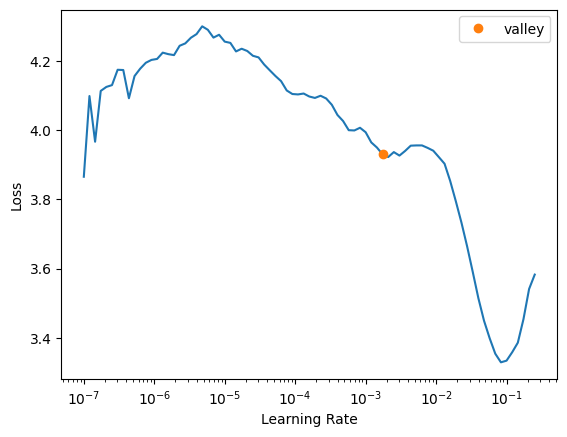

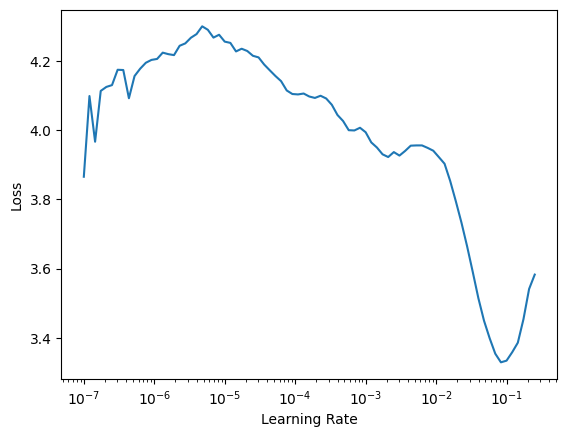

In [5]:
# Define the learner with a pretrained ResNet model
learn = vision_learner(dls, resnet50, pretrained=True, loss_func=MSELossFlat())

learn.freeze()
learn.to_fp16()
learn.lr_find()
learn.recorder.plot_lr_find()


In [7]:
# Fine-tune the model
optimal_lr = 0.1
print("Training the model")
#learn.fine_tune(5)
learn.fit_one_cycle(5, lr_max=optimal_lr)

Training the model


epoch,train_loss,valid_loss,time
0,0.162453,0.036768,05:19
1,0.081112,0.019670,05:16
2,0.044503,0.007063,05:17
3,0.030541,0.011922,05:19
4,0.022673,0.005391,05:17


Evaluating the model


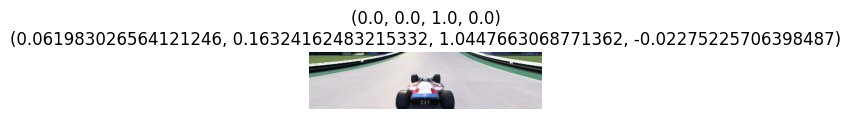

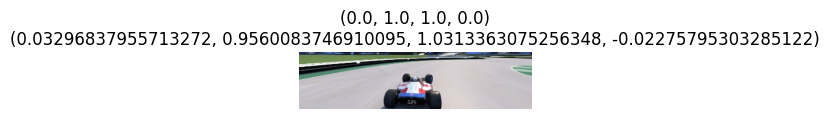

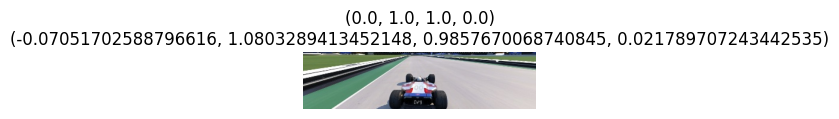

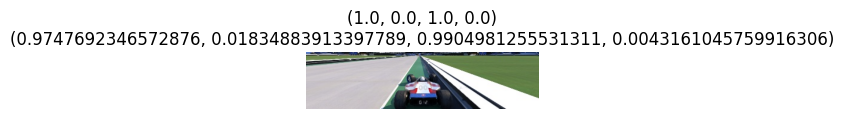

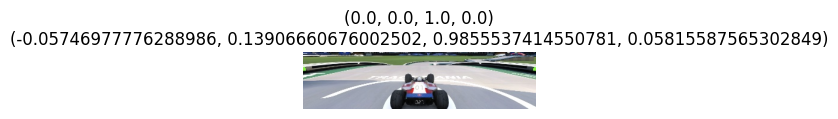

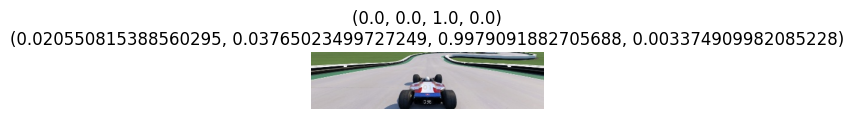

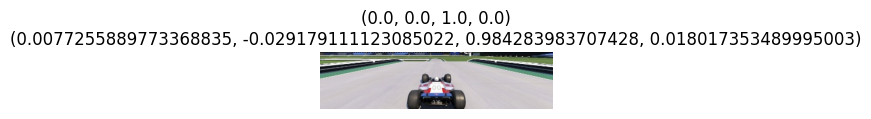

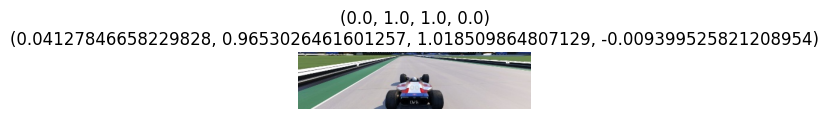

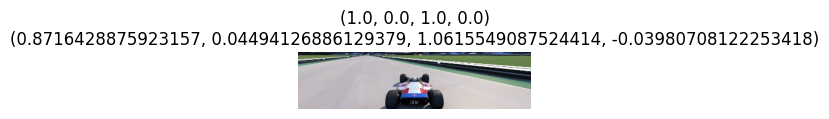

In [8]:
# Evaluate the model on the validation set
print("Evaluating the model")
learn.validate()
for _ in range(9):
    learn.show_results(max_n=1, shuffle=True)


In [ ]:
# Save the entire model for future us
learn.export('trackmania_resnet50_fp16_all_corrected_4.pkl')